Title: 4. Title Generation - Developing the Model
Tags: improving_results
Authors: Ben Hoyle
Summary: This post looks at developing our initial models to include state of the art features to improve results.

# 4. Title Generation - Developing the Model

This post looks at developing our initial models to include state of the art features to improve results.

To recap:

* We have two models: the Ludwig model and the Chollet/Brownlee model. 
* Performance so far has been fairly poor.
* Each model had slightly different characteristics - the Ludwig model produced better formed output but seemed to simply memorise and repeat titles, the Chollet/Brownlee model had a lower loss and appeared to memorise less but produced more nonsensical outputs.

In our last post we identified a number of ways to improve our models:

1. Use GloVe encodings and a shared embedding layer. 
2. Add attention.
3. Add pointers / skip connections between our input and our output.
4. Use a coverage measure.
5. Use different word forms such as lemmas or stems.
6. Use a GAN-style discriminator on the output.
7. Improve our sampling by employing beam search.

We will look at some of these in this post.

In [4]:
# Imports 
import numpy as np
import os

## Pre-trained Shared Embeddings 

First download the glove embeddings text file from [here](http://nlp.stanford.edu/data/glove.6B.zip). This is to be placed in a `/glove` directory.

Then we follow the steps from Ludwig's example to generate our embedding matrix. 

In [12]:
GLOVE_DIR = "glove/"

embeddings_index = {}
# For Python 3 tweaked to add 'rb'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'rb')
for line in f:
    values = line.split()
    # Tweaked to decode the binary text values
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
len(embeddings_index)

400000

In [14]:
list(embeddings_index.keys())[0:10]

['irati',
 'fotiou',
 '8-year',
 'usagi',
 'autobianchi',
 'eldercare',
 'puraskar',
 'dench',
 'ventrally',
 'amsc']

In [16]:
embeddings_index.get('the')

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

---
#### Load and Tokenize Data

Initially we load our data as before. As we are using shared embeddings we will train a common tokenizer on both the claim text and title.

In [17]:
# Set parameters
num_decoder_tokens = 2500 # This is our output title vocabulary
num_encoder_tokens = 2500 # This is our input claim vocabulary
encoder_seq_length = 300 # This is our limit for our input claim length
decoder_seq_length = 22 # This is our limit for our output title length - 20 + 2 for start/stop

In [18]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))
    
print("\n\nAdding start and stop tokens to output")
data = [(c, "startseq {0} stopseq".format(t)) for c, t in data]
                                      
print("\n\nAn example title:", data[0][1])
print("----")
print("An example claim:", data[0][0])

Loading data
30000 samples loaded


Adding start and stop tokens to output


An example title: startseq System and method for session restoration at geo-redundant gateways stopseq
----
An example claim: 
1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reat

In [19]:
from keras.preprocessing import text
t_joint = text.Tokenizer(
                num_words=num_encoder_tokens, 
                lower=True,
                char_level=False,
                oov_token="<UNK>"
)
X_texts = [d[0] for d in data]
Y_texts = [d[1] for d in data]
total_texts = X_texts + Y_texts
t_joint.fit_on_texts(total_texts)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
list(t_joint.word_index.keys())[0:10]

['remapper',
 'inactive',
 'imposes',
 'overestimates',
 'roman',
 'mitigating',
 "location's",
 '56a',
 'buckle',
 'billable']

In [34]:
vocab_size = max([max(x + y) for x, y in zip(X_seqs, Y_seqs)]) + 1
vocab_size

2500

In [23]:
X_seqs = t_joint.texts_to_sequences(X_texts)
Y_seqs = t_joint.texts_to_sequences(Y_texts)
print("Our input sequences (claims) have a max integer value of {0}".format(max([max(x) for x in X_seqs])))
print("Our output sequences (titles) have a max integer value of {0}".format(max([max(y) for y in Y_seqs])))

Our input sequences (claims) have a max integer value of 2499
Our output sequences (titles) have a vocabulary of 2499 words


In [25]:
filtered_seqs = [(x, y) for x,y in zip(X_seqs, Y_seqs) if len(x) <= encoder_seq_length and len(y) <= decoder_seq_length]
X_seqs = [x for x, _ in filtered_seqs]
Y_seqs = [y for _, y in filtered_seqs]

X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest input sequence is {0} tokens long.".format(max_length))

Y_length = [len(y) for y in Y_seqs]
max_length = max(Y_length)
print("Our longest output sequence is {0} tokens long.".format(max_length))

Our longest input sequence is 300 tokens long.
Our longest output sequence is 22 tokens long.


In [39]:
word_embedding_size = 100 # As we are using the Glove 100d data
print('Found {0} word vectors.'.format(len(embeddings_index)))
embedding_matrix = np.zeros((vocab_size, word_embedding_size))

# Filter our vocab to only the used items
words = [(w, i) for w, i in t_joint.word_index.items() if int(i) < vocab_size]

# This is from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/      
for word, i in words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [40]:
embedding_matrix.shape

(2500, 100)

Aside: can I use the embedding matrix as the weights for a dense layer that is multiplied by the probabilities of the decoder output?

In [26]:
print(X_texts[0], X_seqs[0])
print(Y_texts[0], Y_seqs[0])


1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reattach to the network, wherein each DDN causes the MME to send a detach request with a reattach request code to the respective UE.

 [31, 2, 29, 8, 448, 2, 552, 91, 1047, 42, 19, 2, 397, 1, 29, 26, 1959, 5

In [32]:
# Pad the data
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X_seqs, maxlen=encoder_seq_length)
Y = pad_sequences(Y_seqs, maxlen=decoder_seq_length, padding='post')

print("Our X data has shape {0} and our Y data has shape {1}".format(X.shape, Y.shape))

Our X data has shape (25529, 300) and our Y data has shape (25529, 22)


In [64]:
import numpy as np



We can't use the function above as it results in a memory error.

## Models

We have a number of models we can try out. Initially we can run the models with minimal tweaking. Then later we can expand on the better models.

The models we can use are as follows:

1. The Chollet/Brownlee Model based on the [sequential encoder-decoder system](https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/) as described by Jason Brownlee of Machine Learning Mastery, which is in turn based on a [sequence-to-sequence model](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) as described by Francois Chollet; and
2. The Ludwig Model [chatbot encoder-decoder model](https://github.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras) as described by Oswaldo Ludwig.

All use Keras as this point. This helps to simplify our model and let us experiment with the basics.

The original model in 1. is designed based on character data. We can either use at the character level or adapt to use word-level features, e.g. as suggested at the bottom of the Chollet blog post.

The model in 2. uses word-level features. We are thus able to use this with less adaptation.

### Ludwig Model

There are actually two models described by Oswaldo. A first introductory model and a second model that uses an additional adversarial network. The first model is easier to understand so we will start with that.

The first introductory model has the following features:

* A source text input model based around an Embedding layer and an LSTM. The claim features (i.e. words as integers) are projected to a dense vector by the embedding layer and then fed into the LSTM. The last output timestep of the LSTM is then taken as the output. The output of the LSTM can be thought of as a "context vector" that represents the claim.
* A summary input model. This is similar to the source text input model. It has an Embedding layer and an LSTM. It takes a full or partial sequence of integers representing the words in our titles. The output of the last timestep is take as the output of the LSTM. The output of the LSTM can be thought of as an "answer vector" that represents a state of a current answer in time.
* The output of both models, i.e. the context vector and the answer vector are concatenated and fed into a feed forward or Dense layer that outputs a vector the size of our title vocabulary. A softmax activation is used to generate a pseudo-probability value. The output of the model is thus a vector of probabilities across the vocabulary of the title. This can then be compared with a one-hot encoding of the actual word.

In [9]:
# imports
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline
from keras.layers import concatenate

y_vocab_len = num_decoder_tokens # This is our output title vocabulary
X_vocab_len = num_encoder_tokens # This is our input claim vocabulary
X_max_len = encoder_seq_length # This is our limit for our input claim length
y_max_len = decoder_seq_length # This is our limit for our output title length - 20 + 2 for start/stop

# source text input model
inputs1 = Input(shape=(X_max_len,))
am1 = Embedding(X_vocab_len, 128)(inputs1)
am2 = LSTM(128)(am1)
# summary input model
inputs2 = Input(shape=(y_max_len,))
sm1 = Embedding(y_vocab_len, 128)(inputs2)
sm2 = LSTM(128)(sm1)
# decoder output model
decoder1 = concatenate([am2, sm2])
outputs = Dense(y_vocab_len, activation='softmax')(decoder1)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 128)     640000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 22, 128)      320000      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

The model is fairly simple. However, a little bit of work is required to prepare our data for training. There are two main issues we need to address:

* The model requires a one-hot encoding for each word in the title. If our vocabulary is 2500 (relatively small) and our titles are limited to 20 words, we have a matrix of 50,000 items per data sample. If we have 25,000 data samples then we have 1.25 billion items. If each item is a 32 or 64-bit float we have a memory issue.
* The summary model is designed to take partially-complete sequences as the output sequence is built. We thus need to train on various levels of completeness. For example, if our title is 20 words long, we train with 1 word to predict the second word, 2 words to predict the third word, 3 words to predict the fourth word etc.

To address the first issue, we train in smaller sets. For example, we can group 100 examples together and train on these.

To address the second issue, we build up sets of partial titles for each training example.

In [42]:
# We need to split into train and test data
from sklearn.model_selection import train_test_split

# seed for reproducing same results
seed = 9
np.random.seed(seed)

# split the data into training (80%) and testing (20%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [39]:
set_size = 0
for sent in Y[0:100]:
    limit = np.where(sent==2)[0][0]  #  the position od the symbol EOS
    set_size += limit + 1
set_size

1009

In [33]:
Y[0]

array([   1,    6,    3,    5,    4,  383, 1183,  166,  775,    2,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

Ah - it's because we've been reversing our Y.

In [43]:
def generate_set(X, Y, i_end, i):
    """ Generate the data for training/validation from X and Y.
    i_end is the end of the set, i is the start."""
    set_size = 0
    limit_list = list()
    for sent in Y[i:i_end]:
        limit = np.where(sent==2)[0][0]  #  the position od the symbol EOS
        set_size += limit + 1
        limit_list.append(limit)
   
    # We need to change this bit to set our array size based on the limit values
    # Generate blank arrays for the set
    I_1 = np.zeros((set_size, X_max_len))
    I_2 = np.zeros((set_size, y_max_len))
    # This below is a big array
    Y_set = np.zeros((set_size, y_vocab_len))
    count = 0
    # Now we want to create, for each sample, a set of examples for each word in the title
    # Have we just been training on 0 to 100?!?!
    for l in range(0, (i_end - i)):
        # for each X and y in set of NB_SET 
            
        # We need to build the input for the second encoder for the next word in y
        # I.e. for word 3 in the title the input2 consists of words 1 and 2 (using teacher forcing)
            
        # Get length of current title - i.e. where the integer = 2 = stopseq
        limit = limit_list[l]
            
        # We only need to create examples up to the length of the title 
        for m in range(1, limit+1):
                
            # Generate our one-hot y out
            one_hot_out = np.zeros((1, y_vocab_len))
            # This builds our one-hot generation into our training loop
            # The l and m respectively iterate through the samples and the output sequence elements
            one_hot_out[0, Y[l+i][m]] = 1
                
            # Create a blank row/array for a partial input for our summary model - this is fed into the decoder
            # It is of the same size as our title
            partial_input = np.zeros((1, y_max_len))
            # Because we are zero padding add words up to m to end - DOES THIS STILL WORK IF WE ZERO PAD
            # AT THE END? - Yes but we just feed the words with zeros first?
            partial_input[0, -m:] = Y[l+i][0:m]
            
            # This fills in each sample of the training data, i.e. count increments up to set size
            I_1[count, :] = X_train[l+i]
            I_2[count, :] = partial_input
            Y_set[count, :] = one_hot_out
            count += 1
                
        # Shuffle the I_1, I_2 and Y_set vectors for better training - trick from RL
        # - see here - np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X);
        indices = np.random.permutation(I_1.shape[0])
        np.take(I_1, indices, axis=0, out=I_1)
        np.take(I_2, indices, axis=0, out=I_2)
        np.take(Y_set, indices, axis=0, out=Y_set)
    return I_1, I_2, Y_set

In [48]:
# Basing training in sets code on here - https://github.com/ChunML/seq2seq/blob/master/seq2seq.py

# Function to look for saved weights file
def find_checkpoint_file(folder):
    checkpoint_file = [f for f in os.listdir(folder) if 'kerascheckpoint' in f]
    if len(checkpoint_file) == 0:
        return []
    modified_time = [os.path.getmtime(f) for f in checkpoint_file]
    return checkpoint_file[np.argmax(modified_time)]

# Finding trained weights of previous epoch if any
saved_weights = find_checkpoint_file('.')

k_start = 1

# If any trained weight was found, then load them into the model
if len(saved_weights) != 0:
    print('[INFO] Saved weights found, loading...')
    epoch = saved_weights[saved_weights.rfind('_')+1:saved_weights.rfind('.')]
    model.load_weights(saved_weights)
    k_start = int(epoch) + 1

# So instead of X we have [inputs1, inputs2] - this is where we need to fold in 
# - https://github.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/blob/master/train_bot.py

# So we have inputs2 that build up - we have a set of inputs2 up to the length of inputs2

# We need to refactor some of the loops below as functions - we can then apply to test data to generate a validation set

[INFO] Saved weights found, loading...


In [49]:
import math

BATCH_SIZE = 32 # Depends on GPU - most values are around this 32-128 
NB_EPOCH = 2
# Number of examples to group together in a set - 100 is fast / 1000 is too much on an 8-core i7 laptop
# I think 100 is good - 250 takes a time to generate the sets of test data
NB_SET = 250

i_end = 0
num_examples = len(X_train)
num_test = len(X_test)
# Initialise history of accuracy
train_loss = list()
val_loss = list()

# Continue from loaded epoch number or new epoch if not loaded
for k in range(k_start, NB_EPOCH+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(num_examples)
    np.random.shuffle(indices)
    X_train = X_train[indices]
    Y_train = Y_train[indices]
    indices = np.arange(num_test)
    np.random.shuffle(indices)
    X_test = X_test[indices]
    Y_test = Y_test[indices]

    # This for loop rotates through NB_SET samples at a time to avoid memory issues
    # E.g. Training 100 sequences at a time
    for i in range(0, num_examples, NB_SET):
        if i + NB_SET >= num_examples:
            i_end = num_examples
        else:
            i_end = i + NB_SET
        
        # Generate a range for the test data
        i_test = math.floor(i * (num_test/num_examples))
        i_test_end = math.floor(i_end * (num_test/num_examples))
            
        I_1_train, I_2_train, Y_set_train = generate_set(X_train, Y_train, i_end, i)
        I_1_test, I_2_test, Y_set_test = generate_set(X_test, Y_test, i_test_end, i_test)
              
        print('[INFO] Training model: epoch {} - {}/{} samples'.format(k, i, num_examples))
        callback = model.fit(
            [I_1_train, I_2_train], 
            Y_set_train, 
            validation_data=([I_1_test, I_2_test], Y_set_test),
            batch_size=BATCH_SIZE, 
            epochs=1
        )
        train_loss += callback.history['loss']
        val_loss += callback.history['val_loss']
        # Get history and apppend new data to running set here
    model.save_weights('kerascheckpoint_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 2 - 0/20423 samples
Train on 2463 samples, validate on 658 samples
Epoch 1/1
2463/2463 [==============================] - 23s 9ms/step - loss: 2.5461 - val_loss: 3.0267
[INFO] Training model: epoch 2 - 250/20423 samples
Train on 2552 samples, validate on 607 samples
Epoch 1/1
2552/2552 [==============================] - 24s 9ms/step - loss: 2.5839 - val_loss: 2.8048
[INFO] Training model: epoch 2 - 500/20423 samples
Train on 2446 samples, validate on 591 samples
Epoch 1/1
2446/2446 [==============================] - 24s 10ms/step - loss: 2.4230 - val_loss: 2.7162
[INFO] Training model: epoch 2 - 750/20423 samples
Train on 2572 samples, validate on 615 samples
Epoch 1/1
2572/2572 [==============================] - 24s 9ms/step - loss: 2.5362 - val_loss: 2.9778
[INFO] Training model: epoch 2 - 1000/20423 samples
Train on 2526 samples, validate on 604 samples
Epoch 1/1
2526/2526 [==============================] - 25s 10ms/step - loss: 2.5542 - val_loss: 3.0614

[INFO] Training model: epoch 2 - 20250/20423 samples
Train on 1810 samples, validate on 472 samples
Epoch 1/1
1810/1810 [==============================] - 19s 10ms/step - loss: 2.4741 - val_loss: 3.0421


Now we've trained our model we need some code to test it.

In [54]:
# Set up dictionary to translate indices to words
y_dictionary = dict(
            (i, char) for char, i in t_title.word_index.items()
        )

x_dictionary = dict(
            (i, char) for char, i in t_claim.word_index.items()
        )

def seq2text(seq, dictionary):
    text = ''
    for k in seq:
        k = k.astype(int)
        if k > 2 and k < (len(dictionary)-1):
            w = dictionary[k]
            text = text + w + ' '
    return text

def greedy_decoder(X_seq):
    # reformat input seq
    input_seq = np.zeros((1, X_max_len))
    input_seq[0, :] = X_seq
    flag = 0
    prob = 1
    ans_partial = np.zeros((1, y_max_len))
    ans_partial[0, -1] = 1  #  the index of the symbol BOS (begin of sentence)
    for k in range(y_max_len - 1):
        ye = model.predict([input_seq, ans_partial])
        yel = ye[0,:]
        p = np.max(yel)
        mp = np.argmax(ye)
        ans_partial[0, 0:-1] = ans_partial[0, 1:]
        ans_partial[0, -1] = mp
        if mp == 2:  #  the index of the symbol EOS (end of sentence)
            flag = 1
        if flag == 0:    
            prob = prob * p
    text = seq2text(ans_partial[0], y_dictionary)
    return(text, prob)

# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    text, prob = greedy_decoder(X_test[i])
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {} (with prob {}). \n Test title is: {} \n---\n".format(text, prob, Y_test_text))

Sample of claim text: live dual validated independently verified dynamic match audit system comprising first device for transmitting an element effort event data, which data details an effort of an element on an event, and

Predicted title is: system and method for generating a plurality of  (with prob 2.988668487895419e-05). 
 Test title is: match system and event data recorder method thereof  
---

Sample of claim text: method comprising facilitating receipt of two or more images of scene, two or more images being associated with different capture parameters determining intensity at corresponding pixel locations of a

Predicted title is: image processing apparatus and image processing method apparatus and computer readable medium  (with prob 0.007207380954881892). 
 Test title is: method apparatus and computer program product for generating images of scenes having high dynamic range  
---

Sample of claim text: an information terminal for reducing touch point reading errors and relea

#### Comments on Results

The predicted titles seem to be well-formatted and make sense. The problem is they seem to be unrelated to the actual title!

What I think is going on is the second LSTM is over-fitting on the training data. Hence, what you have is a system that memorises the training titles, then picks a memorised training title based on the output of the first LSTM. 

It also appears that the link between the first and second LSTMs is weak - the first encoding or "context vector" does not appear to be heavily influencing the title generation. The prediction of the dense layer seems to be mainly based on the second LSTM. Hence, the dense layer and second LSTM in tandem are over-fitting.

This is backed up by the fact that when we do not shuffle the training data we have rapid convergence to a low loss. This is indicative of over-fitting. It is predicted that by not shuffling we should get rapid convergence but a maintained high validation loss.

#### Options for Further Investigation

We can try adding in shared word embeddings based on Glove encodings (as per the second Ludwig model). The post [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) shows how we convert the text file of Glove encodings into a matrix given a vocabulary from our data.

We can try adding the adversarial discriminator.

### Chollet/Brownlee Model

This is more of a true sequence-to-sequence model, and is thus slightly more involved.

Our model consists of two portions - a portion for training and a portion for inference (i.e. for actually predicting new titles).

In [ ]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

def target_one_hot(input_seqs, seq_max_len, vocab_len):
    """ Convert a sequence of integers to a one element shifted sequence of one-hot vectors."""
    one_hot_out = np.zeros((len(input_seqs), seq_max_len, vocab_len))
    for i, sequence in enumerate(input_seqs):
        for t, word_int in enumerate(sequence):
            if t > 0:
                # Shift decoder target get so it is one ahead
                one_hot_out[i, t-1, word_int] = 1
    return one_hot_out

# We need to convert this for our present problem - this is similar to our generate dataset above
# prepare data for the LSTM
def get_dataset(X, Y, i, i_end, num_decoder_tokens):
    """Return encoder_input_data, decoder_input_data, and decoder_target_data, latter as one-hot"""
    encoder_input_data = X[i:i_end]
    decoder_input_data = Y[i:i_end]
    decoder_target_data = target_one_hot(decoder_input_data, Y.shape[1], num_decoder_tokens)
    return encoder_input_data, decoder_input_data, decoder_target_data

# returns train, inference_encoder and inference_decoder models
def define_models(num_encoder_tokens, num_decoder_tokens, latent_dim):
    # define training encoder
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))
    # Possibly share the embedding below
    decoder_embedding = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    # Need to adjust this line for the embedding
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

def train_model(X_train, Y_train, X_test, Y_test, model, set_size, batch_size, num_decoder_tokens):
    """ Code to train model in sets of set_size."""
    num_examples = len(X_train)
    num_test = len(X_test)
    train_loss = []
    val_loss = []
    # Loop here to avoid memory issues with the target one hot vector
    for i in range(0, num_examples, set_size):
        if i + set_size >= num_examples:
            i_end = num_examples
        else:
            i_end = i + set_size
        # Generate a range for the test data
        i_test = math.floor(i * (num_test/num_examples))
        i_test_end = math.floor(i_end * (num_test/num_examples))
        # Generate small sets of train and test data
        I_1_train, I_2_train, Y_set_train = get_dataset(X_train, Y_train, i, i_end, num_decoder_tokens)
        I_1_test, I_2_test, Y_set_test = get_dataset(X_test, Y_test, i_test, i_test_end, num_decoder_tokens)
        print('[INFO] Training model: {}/{} samples'.format(i, num_examples))
        callback = model.fit(
            [I_1_train, I_2_train], 
            Y_set_train, 
            validation_data=([I_1_test, I_2_test], Y_set_test),
            batch_size= batch_size, 
            epochs=1
        )
        train_loss += callback.history['loss']
        val_loss += callback.history['val_loss']
    return model, train_loss, val_loss

# define model
train, infenc, infdec = define_models(num_encoder_tokens, num_decoder_tokens, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [131]:
# setup variables
epochs = 10
batch_size = 64
set_size = 5000

for e in range(0, epochs):
    print("\n--------\n Epoch - ", e)
    train, tl, vl = train_model(X_train, Y_train, X_test, Y_test, train, set_size, batch_size, num_decoder_tokens)
    train_loss += tl
    val_loss += vl
    model.save_weights("chollet_weights.hdf5", overwrite=True)
    


--------
 Epoch -  0
[INFO] Training model: 0/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 82s 16ms/step - loss: 1.3725 - acc: 0.7448 - val_loss: 1.7861 - val_acc: 0.7027
[INFO] Training model: 5000/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 84s 17ms/step - loss: 1.3737 - acc: 0.7435 - val_loss: 1.7589 - val_acc: 0.7081
[INFO] Training model: 10000/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 87s 17ms/step - loss: 1.3650 - acc: 0.7461 - val_loss: 1.7568 - val_acc: 0.7059
[INFO] Training model: 15000/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 87s 17ms/step - loss: 1.3451 - acc: 0.7480 - val_loss: 1.7507 - val_acc: 0.7123
[INFO] Training model: 20000/20423 samples
Train on 423 samples, validate on 10

In [135]:
# We have some data from a previous model iteration to remove
train_loss = train_loss[82:]
val_loss = val_loss[82:]

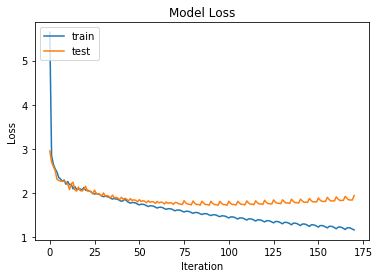

In [136]:
# summarize history for accuracy
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So here we want to stop after around 50 iterations - this is where our training and test loss diverge and marks where over-fitting begins.

In [134]:
train_loss[82:100]

[5.64191109085083,
 2.8468031997680665,
 2.648135330200195,
 2.546439384460449,
 2.476810468673706,
 2.350877471923828,
 2.318929874420166,
 2.2639573631286622,
 2.294969539642334,
 2.1982071876525877,
 2.2616708908081056,
 2.1895121421813966,
 2.1947420234680175,
 2.092662658691406,
 2.1450489292144774,
 2.0810273418426513,
 2.0865359115600586,
 2.0923008041381834]

We then need the inference code to allow prediction and decoding.

The general pattern is as follows:
* Predict the state with infenc using an input X vector.
* Create an initial target vector - is this 0s with first entry the startseq token 1? In the one-hot case, it's a one-hot encoding of one character - would our equivalent just be `array([1])`
* while stop condition is false, where stop condition = len=max_y_len or token=2=stopseq
    * use infdec to predict yhat and return the state of the decoder h and c 
    * remember the yhat 
    * set yhat as the next target sequence and pass generated state
    
I.e. I think we can similar code to Brownlee's or Chollet's model.

In [72]:
I_1_train, I_2_train, Y_set_train = get_dataset(X_train, Y_train, 100, 0, num_decoder_tokens)
I_1_test, I_2_test, Y_set_test = get_dataset(X_test, Y_test, 10, 0, num_decoder_tokens)

In [73]:
print(I_1_train.shape, I_2_train.shape, Y_set_train.shape)
print(I_1_test.shape, I_2_test.shape, Y_set_test.shape)

(0, 300) (0, 22) (0, 22, 2500)
(0, 300) (0, 22) (0, 22, 2500)


In [111]:
def predict_sequence(infenc, infdec, source, decoder_seq_length):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([1])
    # collect predictions
    output = list()
    for t in range(decoder_seq_length):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # update state
        state = [h, c]
        # update target sequence - this needs to be the argmax
        next_int = argmax(yhat[0, 0, :])
        output.append(next_int)
        # It seems like we throw a lot of information away here - can we build in the probabilities?
        target_seq = array([next_int])
        # Check for stopping character
        if next_int == 2:
            break
    return output

In [120]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: method for authenticating an identity of cardholder in financial transaction initiated by cardholder with merchant via first communication medium, said method comprising receiving purchase authenticat

Predicted title is: a more more dimensional more more more more more more more dimensional dimensional more more more more more dimensional dimensional more more . 
 Test title is: methods and systems for authenticating an identity of a in a financial transaction  
---

Sample of claim text: an array substrate including display area and peripheral area, wherein display area includes plurality of thin film transistors provided on base substrate, first transparent electrodes electrically co

Predicted title is: a more more dimensional more more more more more more more dimensional dimensional more more more more more dimensional dimensional more more . 
 Test title is: array substrate and manufacturing method thereof touch display device  
---

Sample of claim text: m

We have a lower loss than the Ludwig model but our output is the same for all predicted titles: a seemingly random set of repetitive phrases.

I have seen this form of behaviour before. One method of avoiding it was to play with the temperature of the sampling. This is explained [here](https://stats.stackexchange.com/questions/255223/the-effect-of-temperature-in-temperature-sampling) as set out below.

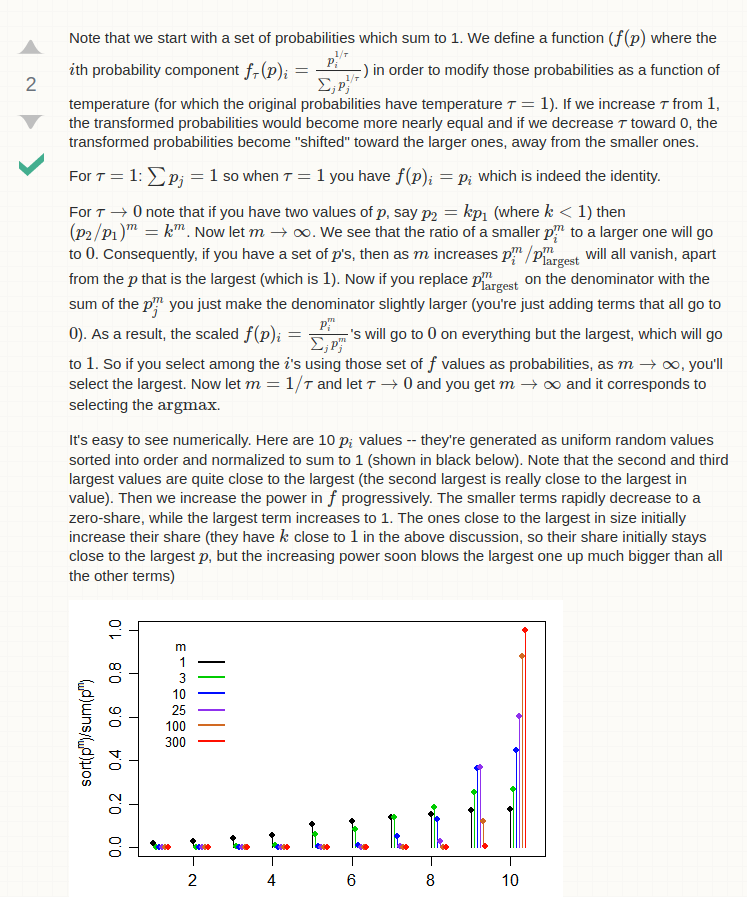

In [115]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [119]:
state = infenc.predict(X_test[1])
# start of sequence input
target_seq = array([1])
# collect predictions
output = list()
for t in range(decoder_seq_length):
    # predict next char
    yhat, h, c = infdec.predict([target_seq] + state)
    # update state
    state = [h, c]
    # update target sequence - this needs to be the argmax
    next_int = sample(yhat[0, 0, :])
    output.append(next_int)
    # It seems like we throw a lot of information away here - can we build in the probabilities?
    target_seq = array([next_int])
    # Check for stopping character
print(output)

[1226, 1415, 2180, 1370, 873, 1059, 18, 414, 364, 1926, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [124]:
def predict_sequence(infenc, infdec, source, decoder_seq_length, temp=1.0):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([1])
    # collect predictions
    output = list()
    for t in range(decoder_seq_length):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # update state
        state = [h, c]
        # update target sequence - this needs to be the argmax
        next_int = sample(yhat[0, 0, :], temp)
        output.append(next_int)
        # It seems like we throw a lot of information away here - can we build in the probabilities?
        target_seq = array([next_int])
        # Check for stopping character
        if next_int == 2:
            break
    return output

In [122]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: character string recognition method for recognizing character string comprising steps of imaging character string on medium to obtain image data first step in which first projection data of image data

Predicted title is: fidelity awareness screening using regions filtering said program . 
 Test title is: character string recognition method and device  
---

Sample of claim text: device for selectively modifying transmission performance of frame data having data size and preset transmission clock rate, frame data being transmitted through transmission interface toward an image

Predicted title is: dependent accessory candidate lock assignment algorithms initiated devices using manufacture . 
 Test title is: modification device and method for selectively modifying transmission performance of image frame data  
---

Sample of claim text: an apparatus for use as switch, comprising ring tag including ring element with an rfid circuit, ring tag attached to rotatable on

In [125]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length, 0.5)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: method for providing service address space, comprising providing service with service address space attached to main processor, wherein main processor is provided with main address space, wherein serv

Predicted title is: networked engine memory secured same . 
 Test title is: providing service address space for diagnostics collection  
---

Sample of claim text: an image processing device comprising filter control unit configured to on basis of an prediction mode, filter processing turned on or off as to neighboring pixels that are located to current block fo

Predicted title is: determination virtual rfid swap manufacturing thin session mapping advanced wireless asset sequences telematics . 
 Test title is: image processing device and method  
---

Sample of claim text: processor implemented method for operating client computing device to allow user to interact with network sites over network interface, method comprising initiating via processor operation of bro

In [126]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length, 0.1)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: method for using persistent party for comprising via computing device, global array according to hierarchical server architecture, wherein hierarchical server architecture enables user to create and h

Predicted title is: a volatile dimensional dimensional more more more more more more more dimensional determine dimensional more more more dimensional dimensional more more more . 
 Test title is: persistent party  
---

Sample of claim text: an input device comprising selecting section for selecting pair from among plurality of x electrodes and y electrodes disposed as being spaced apart from each other detecting section for detecting tou

Predicted title is: a volatile dimensional more more more dimensional more more more more more dimensional dimensional dimensional more more more more dimensional dimensional more . 
 Test title is: input device input control method program and electronic apparatus  
---

Sample of claim text: an image processing apparatus compri

So low temperature reproduces the default results.

In [127]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length, 1.5)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: computer-implemented method for analyzing data representative of media material having layout, comprising identifying block segments associated with body text in media material and determining which o

Predicted title is: electrode localization funds link being . 
 Test title is: methods and systems for analyzing data in media material having layout  
---

Sample of claim text: computer interface system comprising at least one camera operable to create an image of by user, comprising plurality of features and b processing module operable to receive created image of and deter

Predicted title is: unstructured log entity plural adapted performed . 
 Test title is: for camera calibration and as a gesture based 3d interface device  
---

Sample of claim text: computer-implemented method, comprising receiving, by computing system, multiple portions of text that were input into different types of fields associated with resource selecting i first threshold va

Predicted 

In [138]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {} \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: an id document comprising document core layer having two opposed surfaces and on at least one surface of document core layer, comprising top layer middle layer and bottom layer, wherein point of botto

Predicted title is: removal human partitioning related recording platforms  
 Test title is: id documents having a multi layered structure  
---

Sample of claim text: method for presenting story content relating to and location of interest, method comprising receiving query comprising an intersection criteria, intersection criteria comprising location and of intere

Predicted title is: item many step chips overlay transmitting  
 Test title is: systems and methods for collaborative in a virtual space  
---

Sample of claim text: method of forming an image using plurality of comprising receiving at least one raster of image pixels each having discrete value for each of for raster associated with defective modifying values of p

Predicted title is: held appearance ex

#### Comments on Results


#### Options for Further Investigation



## Summary

In this post we have:
* Constructed two sequence-to-sequence models.
* Applied theses models to our patent claim and title data.
* Looked at the performance of each model, including identifying strengths and weaknesses.